## Sequential Quadratic Programming
1 a i

In [46]:
using FiniteDiff
using Optim
using ForwardDiff
using ForwardDiff: gradient, hessian, jacobian
using Random
using LinearAlgebra
using Plots
using DataFrames
using PrettyTables

# Define the objective function f(x)
function Rosenbrock(X, a, b)
    sum = 0
    for i in 1:length(X)-1
        sum += (a*(1-X[i])^2 + b*(X[i+1]-X[i]^2)^2)
    end
    return sum
end


# Define the constraint set

function constraint(X, r)
    sum = 0
    for i in 1:length(X)
        sum += X[i]^2
    end
    return sum - r
end

# Define the Lagrangian function
function lagrangian(domain, a, b, r, λ)
    x = domain[1:end-1]
    λ = domain[end]
    sum = Rosenbrock(x, a, b)
    cost = λ*constraint(x, r)
    return sum + cost
end

# Define the gradient of the Lagrangian using ForwardDiff
function gradient_lagrangian(domain, a, b, r)
    x = domain[1:end-1]
    λ = domain[end]
    
    ∇L_x = ForwardDiff.gradient(x -> lagrangian([x; λ], a, b, r, λ), x)
    
    return ∇L_x
end

# Function to compute gradient using finite differences
function finite_diff_lagrangian(domain, a, b, r; ϵ=1e-15)
    x = domain[1:end-1]
    λ = domain[end]
    
    ∇L_x = FiniteDiff.finite_difference_gradient(x -> lagrangian([x; λ], a, b, r, λ), x)
    
    return ∇L_x
end

# Define the function to sample points uniformly on the unit square
function sample_points_uniformly(n_points, n_dimensions)
    points = rand(n_points, n_dimensions)
    return points
end

function test_gradients(n, k, a, b, r)
    points = sample_points_uniformly(k, n)  # Sample points uniformly
    errors_fd = zeros(k)
    errors_forward_diff = zeros(k)
    summation =0
    for i in 1:k
        domain = points  

        ∇L_x_fd = finite_diff_lagrangian(domain, a, b, r)
        ∇L_x_forward_diff = gradient_lagrangian(domain, a, b, r)
        
        # Calculate RMSE for finite differences
        errors_fd[i] = norm(∇L_x_fd .- ∇L_x_forward_diff).^2
        summation += errors_fd[i]
        # Calculate RMSE for ForwardDiff
    end
    mean_sum = summation / k
    RMSE = sqrt.(mean_sum)
    return RMSE
end


test_gradients (generic function with 1 method)

In [47]:
using Statistics
# Test the gradients
n = 5
k = 100
a = 1
b_values = [1, 100, 1000, 1e5, 1e7, 1e9, 1e11]  # Different values of b to test

for b in b_values
    errors_fd = test_gradients(n, k, a, b, n)
    println("Results for b = $b:")
    println("RMSE using finite differences: $(errors_fd)")
end

Results for b = 1.0:
RMSE using finite differences: 6.219296215002556e-8


Results for b = 100.0:
RMSE using finite differences: 2.492012841777413e-6


Results for b = 1000.0:
RMSE using finite differences: 1.5279486772530257e-5


Results for b = 100000.0:
RMSE using finite differences: 0.00214606054183133


Results for b = 1.0e7:
RMSE using finite differences: 0.14179814385062356


Results for b = 1.0e9:
RMSE using finite differences: 15.79181164388655


Results for b = 1.0e11:
RMSE using finite differences: 1600.0208849139558


We can see from the output that RMSE grows as b increases, however the results are still closde as the RMSE is still quite small. We then test with larger values of b to see when finite differences stop working well. The reason why increasing the value of b increases RMSE is that a small pertubation with a larger b leads to larger differences in the Rosenbrock equation and hence the lagrangian. We can see from the results up to b=1e7 RMSE is less than 1, however after 1e9 we can see this is when finite differences stop working so well.

1 a ii

In [48]:
# Implement Newton's very specifically for this lagrangian method
function newton(x0, a, b, r, λ; tol = 1e-6, itermax = 100, trace=nothing)
    x = copy(x0)
    iter = 0
    while iter < itermax
        # Calculate the gradient and the Hessian of the Lagrangian
        fx  = lagrangian([x; λ], a, b, r, λ)
        Df  = ForwardDiff.gradient(x -> lagrangian([x; λ], a, b, r, λ), x)
        if Df == zeros(length(x0))
            return (;fx = lagrangian([x; λ], a, b, r, λ), x, iter)
        end
        D²f = ForwardDiff.hessian(x -> lagrangian([x; λ], a, b, r, λ), x)

        # Search direction
        sk = -D²f \ Df

        # Update x
        x .= x + sk

        # Check for the stop criterion
        err = norm(Df)
        if err < tol
            break
        end

        iter += 1
        if trace !== nothing
            trace(x, iter, fx)
        end
    end
    return (;fx = lagrangian([x; λ], a, b, r, λ), x, iter)
end


newton (generic function with 1 method)

In [49]:
a=1
b=1
r=2
λ = 0
x0 = zeros(2)
println(newton(x0, a, b, r, λ ))
# x0 only seems to work with floats, so just being aware of this is useful for future cases

(fx = 0.0, x = [1.0, 1.0], iter = 2)


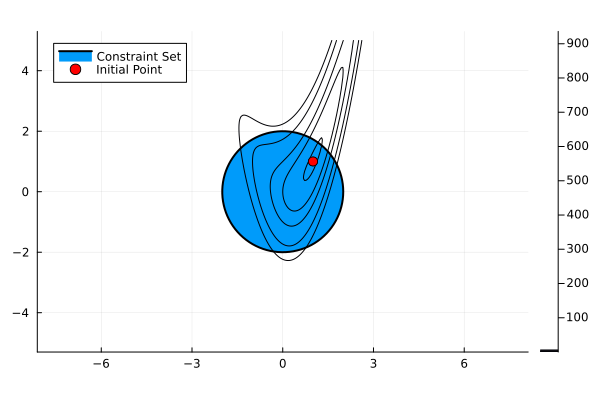

In [50]:
#  Creating the plot
# Call the newton function
result = newton(x0, a, b, r, λ)

# Collect the values of x^k at each step
x_steps = []

function callback(x, iter, fx)
    push!(x_steps, x)
end

newton(x0, a, b, r, λ, trace=callback)

# Define the constraint set plot
function plot_constraint_set(r)
    θ = LinRange(0, 2π, 100)
    x = r .* cos.(θ)
    y = r .* sin.(θ)
    plot!(x, y, fill=true, aspect_ratio=:equal, linecolor=:black, linewidth=2, label="Constraint Set")
end

# Define the contours of f plot
function plot_contours(a, b)
    x = LinRange(-5, 5, 200)
    y = LinRange(-5, 5, 200)
    contour!(x, y, (x, y) -> Rosenbrock([x, y], a, b), levels=[0.1, 1, 2, 4, 6]) #  Creating the plot
end
# Plot the progress of the algorithm
p = plot()
plot_constraint_set(r)
plot_contours(a, b)
for (i, x) in enumerate(x_steps)
    scatter!([x[1]], [x[2]], markersize=5, markercolor=:red, label=i == 1 ? "Initial Point" : "", legend=:topleft)
end
display(p)

1 a iii

In [51]:
a=1
b=1
r=2
λ = 1
x0 = zeros(2)

b_values = [1, 100, 1000, 1e5, 1e7, 1e9, 1e11]  # Different values of b to test
x_values = [ [10.0, 10.0], [50.0, 50.0], [-200.0, 1500.0], [12345.0, -6789.0]]

for b in b_values
    result = newton(x0, a, b, r, λ )
    println("Results for b = $b:")
    println("Optimisation: $(result)")
end
b = 1
for x in x_values
    result = newton(x, a, b, r, λ )
    println("Results for x = $x:")
    println("Optimisation: $(result)")
end


Results for b = 1.0:
Optimisation: (fx = -1.4745270468740155, x = [0.45339765151640377, 0.10278471520029514], iter = 4)
Results for b = 100.0:
Optimisation: (fx = -1.4564489497067452, x = [0.424345197650557, 0.17828598690008937], iter = 6)
Results for b = 1000.0:
Optimisation: (fx = -1.4561609057553957, x = [0.42390324404464796, 0.17951444586571064], iter = 7)
Results for b = 100000.0:
Optimisation: (fx = -1.4561289783648783, x = [0.4238542938576046, 0.17965066591486947], iter = 8)
Results for b = 1.0e7:
Optimisation: (fx = -1.456128658846272, x = [0.4238538040176953, 0.17965202921506793], iter = 8)
Results for b = 1.0e9:
Optimisation: (fx = -1.4561286556510615, x = [0.42385379911926235, 0.17965204284817998], iter = 8)
Results for b = 1.0e11:
Optimisation: (fx = -1.4561286556191093, x = [0.42385379907027804, 0.17965204298451115], iter = 100)
Results for x = [10.0, 10.0]:
Optimisation: (fx = -1.4745270468740153, x = [0.4533976515164039, 0.10278471520029517], iter = 10)
Results for x = [

For the Rosenbrock function, which has a narrow and curved valley leading to the minimum, the choice of the initial guess can significantly impact the convergence behavior.

Since the Rosenbrock function has a global minimum at \( (1, 1) \), it's essential to choose an initial guess that is relatively close to this minimum for efficient convergence. The closer the initial guess is to the true minimum, the faster the convergence is likely to occur.

If the initial guess is far from the true minimum, it might take longer for the optimisation algorithm to converge, or it might even get stuck in a local minimum or saddle point.

To ensure convergence, especially with gradient-based optimisation algorithms like Newton's method, it's advisable to choose an initial guess that is within the vicinity of the true minimum. However, it's worth noting that even if the initial guess is not very close to the true minimum, the algorithm might still converge if given enough iterations and appropriate step size control mechanisms.

Therefore, for the Rosenbrock function, choosing an initial guess that is relatively close to \( (1, 1) \) would likely ensure faster convergence. As for how close you need to make \( x_0 \) to the true minimum to ensure convergence, it's difficult to give an exact threshold since it depends on various factors such as the specific optimisation algorithm, tolerance settings, and characteristics of the function landscape. However, starting within a few units of distance from the true minimum should generally lead to satisfactory convergence behavior for Newton's method with appropriate parameters.

We can see from above that increasing the value of b does not effect the optimisation. Additionally, changing the values of x increases the number of iterations needed to find the optimum but does not effect the accuracy.

1 a iv

In [52]:
# Repeating the same as above but changing the values of r
b=1
r=2
λ = 0
x0 = zeros(2)
r_values = [0.5, 1, 100]
x_values = [[12345.0, -6789.0]]
λ_values = [0, 1, 10]
for λ in λ_values
    for r in r_values
        result = newton(x0, a, b, r, λ )
        println("Results for r = $r and λ = $λ:")
        println("Optimisation: $(result)")
    end
end


Results for r = 0.5 and λ = 0:
Optimisation: (fx = 0.0, x = [1.0, 1.0], iter = 2)
Results for r = 1.0 and λ = 0:
Optimisation: (fx = 0.0, x = [1.0, 1.0], iter = 2)
Results for r = 100.0 and λ = 0:
Optimisation: (fx = 0.0, x = [1.0, 1.0], iter = 2)
Results for r = 0.5 and λ = 1:
Optimisation: (fx = 0.025472953125984688, x = [0.45339765151640377, 0.10278471520029514], iter = 4)
Results for r = 1.0 and λ = 1:
Optimisation: (fx = -0.47452704687401537, x = [0.45339765151640377, 0.10278471520029514], iter = 4)
Results for r = 100.0 and λ = 1:
Optimisation: (fx = -99.47452704687402, x = [0.45339765151640377, 0.10278471520029514], iter = 4)
Results for r = 0.5 and λ = 10:
Optimisation: (fx = -4.0908471677241005, x = [0.09078541279813622, 0.0007492719251752445], iter = 2)
Results for r = 1.0 and λ = 10:
Optimisation: (fx = -9.0908471677241, x = [0.09078541279813622, 0.0007492719251752445], iter = 2)
Results for r = 100.0 and λ = 10:
Optimisation: (fx = -999.0908471677242, x = [0.090785412798136

It appears from the results above the biggest factor is the value of lambda, as this affects and changes the constraint and when lambda is not equal to 0 we do not converge to the real minimum.

## Penalty method
1 bi

In [53]:
using ForwardDiff
using Optim

a = 10
b = 10
r = 10
function Rosenbrock(x, a, b, r)
    sum = 0
    for i in 1:length(x)-1
        calc = a*(1-x[i])^2 + b*(x[i+1]-x[i])^2
        sum += calc
    end
    return sum
end

function constraint(x, r)
    sum = 0
    for i in 1:length(x)
        sum += x[i]^2
    end
    return sum - r
end

function solve_penalty(P, x0, a, b, r)
    # Set up the penalized objective 
    function objective(x)
        return Rosenbrock(x, a, b, r) + P * norm(constraint(x, r))^2
    end

    # Solve with LBFGS method
    ret = optimize(objective, x0, LBFGS())

    # Keep things interpretable
    return ret
end

solve_penalty (generic function with 1 method)

In [54]:
a=10
b=10
r=10
println(solve_penalty(1e12, zeros(10), a, b, r))

 * Status: success

 * Candidate solution
    Final objective value:     1.000000e+14

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = 0.00e+00 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    0
    f(x) calls:    1
    ∇f(x) calls:   1



We see that we do not converge to the minimum of the Rosenbrock function.

1 b ii

In [55]:
function penalty_method(x0, a, b, r; tol = 1e-12, γ = 10, trace = false)
    iter = 0
    num_evals = 0
    P = 1
    x = copy(x0)
    while true
        # Solve with penalty parameter P
        ret = solve_penalty(P, x, a, b, r)

        # Keep track of the total number of function evals (really, LBFGS steps in this case)
        num_evals += ret.iterations

        # If P is large enough, we're done
        P > 1e12 && break

        # Otherwise we keep going, using the solution as a warmstart
        # Increment P up
        x .= ret.minimizer  # Update x with the minimizer found
        gx = constraint(x, r)
        P *= γ
        iter += 1

        trace && @info "Trace" iter P penalty_violation = gx
    end

    return (; fx = Rosenbrock(x, a, b, r), x, iter, num_evals)
end


penalty_method (generic function with 1 method)

In [56]:
x0 = zeros(10)
penalty_ret = penalty_method(x0, a, b, r, tol=1e-12, trace=true)

┌ Info: Trace
│   iter = 1
│   P = 10
│   penalty_violation = -1.6370904631912708e-11
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 2
│   P = 100
│   penalty_violation = -1.6370904631912708e-11
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 3
│   P = 1000
│   penalty_violation = -1.6370904631912708e-11
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 4
│   P = 10000
│   penalty_violation = -1.6370904631912708e-11
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 5
│   P = 100000
│   penalty_violation = -1.6370904631912708e-11
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 6
│   P = 1000000
│   penalty_violation = -1.6370904631912708e-11
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 7
│   P = 10

(fx = 1.0261426364130259e-20, x = [0.9999999999898055, 0.9999999999897117, 1.0000000000014042, 0.9999999999989639, 1.0000000000071068, 0.9999999999948097, 1.0000000000080815, 0.9999999999988493, 0.9999999999982205, 1.0000000000048612], iter = 13, num_evals = 29)

We now see that even though we are not at fx = 0 we are extremely close and this algorothm is doing a much better job that only using a large penalty fixed penalty.

1 b iii

In [57]:
# Repeating with b = 1000
x0 = zeros(10)
b = 1000
penalty_ret = penalty_method(x0, a, b, r, tol=1e-12, trace=true)

┌ Info: Trace
│   iter = 1
│   P = 10
│   penalty_violation = -2.5121238422798342e-11
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 2
│   P = 100
│   penalty_violation = -2.5121238422798342e-11
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 3
│   P = 1000
│   penalty_violation = -2.5121238422798342e-11
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 4
│   P = 10000
│   penalty_violation = -2.5121238422798342e-11
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 5
│   P = 100000
│   penalty_violation = -2.5121238422798342e-11
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 6
│   P = 1000000
│   penalty_violation = -2.5121238422798342e-11
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 7
│   P = 10

(fx = 2.2677849562173716e-21, x = [0.9999999999968074, 0.9999999999979332, 0.99999999999822, 0.9999999999988092, 0.9999999999991825, 0.9999999999989342, 0.9999999999992177, 0.9999999999994769, 0.9999999999994384, 0.9999999999994189], iter = 13, num_evals = 33)

We can see that increasing b makes the final result a bit less accurate but it still does a very good job at getting close to the true minimum.

In [58]:
# Repeating with r = 1
x0 = zeros(10)
r = 1
penalty_ret = penalty_method(x0, a, b, r, tol=1e-12, trace=true)

┌ Info: Trace
│   iter = 1
│   P = 10
│   penalty_violation = 2.795947481551
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 2
│   P = 100
│   penalty_violation = 0.654633476036222
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 3
│   P = 1000
│   penalty_violation = 0.09103144601159219
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 4
│   P = 10000
│   penalty_violation = 0.0096409346232047
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 5
│   P = 100000
│   penalty_violation = 0.0009702065862569054
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 6
│   P = 1000000
│   penalty_violation = 9.7082624478384e-5
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:23
┌ Info: Trace
│   iter = 7
│   P = 10000000
│   penalty_violation = 

(fx = 41.96669048097459, x = [0.32465401158929336, 0.32420465515640057, 0.3232927224359817, 0.3218913865122807, 0.31995942325991716, 0.31743999839743675, 0.31425899536007673, 0.3103228359474531, 0.3055157258802307, 0.2996962506695224], iter = 13, num_evals = 203)

Here it is impossible to converge to all x's being 1 as this is outside the feasible set, so we can assume because of how well the algorithm has previously been working that it has converged to the minimum in the feasible set. So even though fx is large our algorithm may still be doing well.

## Augmented Lagrangian
1 c i

In [59]:

function augmented_lagrangian_inner(f, g, P, a, b, r, λ, x0)
    function objective(x, a, b, r, λ)
        gx = g(x, r)
        f(x, a, b) + 0.5 * P * norm(gx)^2 + dot(λ, gx)
    end

    # Solve the augmented problem
    ret = optimize(x -> objective(x, a, b, r, λ), x0, LBFGS())
    return ret.minimizer
end

function augmented_lagrangian(f, g, a, b, r, x0; tol = 1e-8, γ = 10, trace=false)
    gx = g(x0, r)
    λ = ones(size(gx))  # Initialize λ as ones
    P = 1.0
    x = copy(x0)
    num_evals = 0
    iter = 0

    while true 
        # Solve the inner problem 
        x′ = augmented_lagrangian_inner(f, g, P, a, b, r, λ, x)
        num_evals += 1
        iter += 1
        
        # Update λ
        gx = g(x′, r)
        λ′ = λ .+ gx .* P

        # Check if we're violating the constraints
        err = norm(λ′ .- λ)^2
        if err < tol
            break
        else # otherwise keep going
            P *= γ
            x .= x′
            λ .= λ′
            trace && @info "Trace" iter P err penalty_violation = gx
        end
    end

    return (fx = f(x, a, b), x, λ, num_evals, iter)
end


augmented_lagrangian (generic function with 1 method)

In [60]:
a=10
b=10
r=10
println(augmented_lagrangian(Rosenbrock, constraint, a, b, r, zeros(10), trace=true))

(fx = 1.3812280171802472e-9, x = [0.9999988408065805, 0.9999986148304835, 0.9999985164715609, 0.9999984473890575, 0.999998338498396, 0.9999980809090433, 0.9999974170315276, 0.9999956829888581, 0.999991144734583, 0.9999792640706099], λ = fill(3.0251543204684594e-5), num_evals = 4, iter = 4)


┌ Info: Trace
│   iter = 1
│   P = 10.0
│   err = 0.5130453261856635
│   penalty_violation = -0.7162718242299242
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:39
┌ Info: Trace
│   iter = 2
│   P = 100.0
│   err = 0.0753873258773773
│   penalty_violation = -0.027456752516890504
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:39
┌ Info: Trace
│   iter = 3
│   P = 1000.0
│   err = 8.336418695770802e-5
│   penalty_violation = -9.130399057966088e-5
└ @ Main c:\Users\s2155729\Downloads\Attempt problem set 5 (1).ipynb:39


We eventually find the true minimum on the third iteration, where P=1000.

1 c ii

In [61]:
using DataFrames
using PrettyTables

function compare_methods(a, b, r, x0; penalty_parameters=[1.0, 10.0, 100.0], augmented_parameters=[(tol=1e-8, γ=10), (tol=1e-6, γ=5)], verbose=false)
    results = DataFrame(Method = String[], Penalty_Parameter = Float64[], Penalty_Iter = Int64[], Augmented_Iter = Int64[], Penalty_Obj = Float64[], Augmented_Obj = Float64[])
    
    for P in penalty_parameters
        for params in augmented_parameters
            penalty_result = penalty_method(x0, a, b, r)
            result_augmented = augmented_lagrangian(Rosenbrock, constraint, a, b, r, x0; tol=params.tol, γ=params.γ)
            
            push!(results, ("Penalty", P, penalty_result[3], result_augmented[5], penalty_result.fx, result_augmented.fx))
            push!(results, ("Augmented Lagrangian", P, penalty_result[3], result_augmented[5], penalty_result.fx, result_augmented.fx))
        end
    end
    
    pretty_table(results)
end


compare_methods (generic function with 1 method)

In [62]:
a = 1.0
b = 100.0
r = 10.0
x0 = [0.0, 0.0]

compare_methods(a, b, r, x0)


┌──────────────────────┬───────────────────┬──────────────┬────────────────┬─────────────┬───────────────┐
│               Method │ Penalty_Parameter │ Penalty_Iter │ Augmented_Iter │ Penalty_Obj │ Augmented_Obj │
│               String │           Float64 │        Int64 │          Int64 │     Float64 │       Float64 │
├──────────────────────┼───────────────────┼──────────────┼────────────────┼─────────────┼───────────────┤
│              Penalty │               1.0 │           13 │              3 │     1.52537 │      0.414004 │
│ Augmented Lagrangian │               1.0 │           13 │              3 │     1.52537 │      0.414004 │
│              Penalty │               1.0 │           13 │              2 │     1.52537 │      0.349046 │
│ Augmented Lagrangian │               1.0 │           13 │              2 │     1.52537 │      0.349046 │
│              Penalty │              10.0 │           13 │              3 │     1.52537 │      0.414004 │
│ Augmented Lagrangian │             

In the provided optimisation problem, both the penalty method and the augmented Lagrangian method are converging to similar solutions regardless of variations in their respective parameters. This suggests that the problem may have characteristics that cause the optimisation algorithms to converge to a particular solution irrespective of the specific techniques used or the parameters chosen. The rapid increase in the penalty parameter in the penalty method may lead to the domination of the penalty term over the original objective function, resulting in a similar solution to that obtained by the augmented Lagrangian method.



## Parameter Transformation
1 d i

In [63]:
function h(Z, r)
    n = length(Z) + 1
    X = zeros(n)

    exp_Z = exp.(Z)

    exp_sum = sum(exp_Z)

    for i in 1:n-1
        X[i] = (exp(Z[i]) / (1 + exp_sum))^(1/2)
    end
    X[n] = (1 / (1 + exp_sum))^(1/2)
    return sqrt(r) * X
end

function h_inv(X)
    n = length(X)
    Z = zeros(n-1)
    for i in 1:n-1
        Z[i] = 2 * log(X[i]/X[n])
    end
    return Z
end

function Rosenbrock(X, a, b)
    sum = 0
    for i in 1:length(X)-1
        sum += (a*(1-X[i])^2 + b*(X[i+1]-X[i]^2)^2)
    end
    return sum
end

function constraint(X, r)
    sum = 0
    for i in 1:length(X)
        sum += X[i]^2
    end
    return sum - r
end

function Rosenbrock_unconstrained(Z, a, b, r)
    X = h(Z, r)
    return Rosenbrock(X, a, b)
end

using Optim
a = 1
b = 1
r = 2
z0 = [5.0]

# Define the objective function to pass to Optim
objective_function(Z) = Rosenbrock_unconstrained(Z, a, b, r)

# Call the optimization routine
result = optimize(objective_function, z0, LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     7.039971e-18

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.48e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.42e+05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.37e-06 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.95e+11 ≰ 0.0e+00
    |g(x)|                 = 4.19e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    14
    ∇f(x) calls:   14


Whenever possible re-parameterisation is the quickest method and requires fewest iterations especially when r is large or the constraint is more challenging. We take away from this whenever possible first look to re-parameterise this is likely due to we are optimising with respect to one less variable and we are optimising on a convex function which should always be something we are looking to opimise on.